## Imports

In [1]:
from pathlib import Path
import warnings

import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
from ipywidgets import interact

from fusion import optimize
from utils import hyperspectral2RGB, hyperspectral2RGBvolume, bin_data
from utils import RESOURCES_PATH

RESOURCES_PATH = Path("/Users/federicosimoni/Library/Mobile Documents/com~apple~CloudDocs/Università/Tesi/Code/CS-FLIM_lab/20240612")

CMOS_PATH = RESOURCES_PATH / "3beads_triangle_w4_rec_Hil2D_FOVcorrected.mat"
SPC_PATH = RESOURCES_PATH / "480_3beads_triangle_505_500_575_SPC_raw_proc_tlxy.mat"
LAMBDA_PATH = RESOURCES_PATH / "575_Lambda_L16.mat"

# CMOS_PATH = RESOURCES_PATH / "kidney_cells_520_610_w4_rec_Hil2D_FOVcorrected.mat"
# SPC_PATH = RESOURCES_PATH / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
# LAMBDA_PATH = RESOURCES_PATH / "610_Lambda_L16.mat"

XY_DIM = 128
ZOOMED = False
Z_START = 5
Z_END = 12

## Data loading

In [2]:
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(f["I"])

if cmos.ndim == 3:
    cmos = np.transpose(cmos, (1, 2, 0))
    zoom_factor = 8
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
    cmos = np.transpose(cmos, (2, 1, 0))
else:
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM))
    cmos = np.transpose(cmos, (1, 0))

cmos = cmos[Z_START:Z_END]
cmos = cmos / cmos.max()

# MASK
# maskcmos = cmos > (0.1 * np.max(cmos))
# cmos = cmos * maskcmos

original_spc = sp.io.loadmat(SPC_PATH)["im"]
original_spc[:, :, 0, 0] = original_spc[:, :, 1, 0]

original_t = np.squeeze(sp.io.loadmat(SPC_PATH)["t"])
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

## Zoomed image
If working with a zoomed image, activate this cell to cut the CMOS image accordingly.

In [3]:
zoom_factor = 8
if ZOOMED:
    cut_cmos = cmos[:, XY_DIM // 2 - XY_DIM // zoom_factor:XY_DIM // 2 + XY_DIM // zoom_factor,
               XY_DIM // 2 - XY_DIM // zoom_factor:XY_DIM // 2 + XY_DIM // zoom_factor]
    cmos = cut_cmos

## Time binning and initial plots

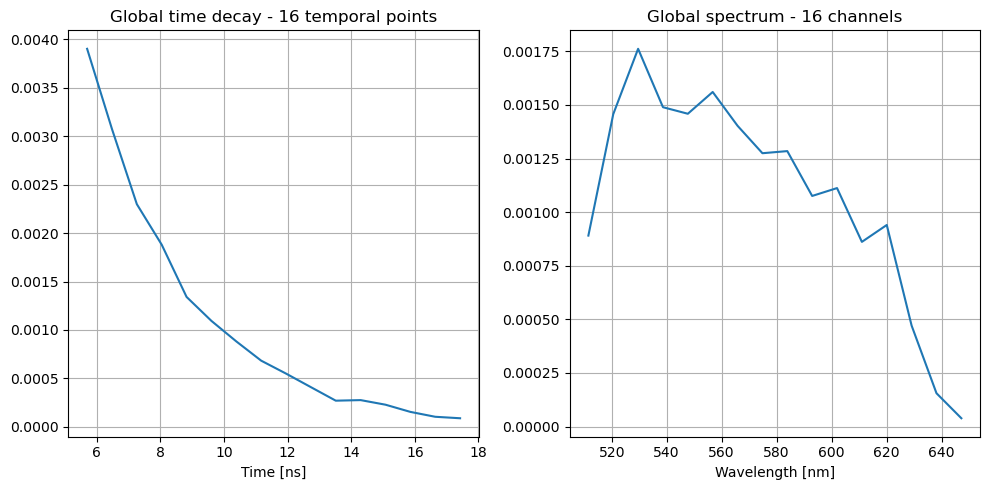

In [4]:
# cut the time (first)
curve = np.squeeze(np.sum(original_spc, axis=(1, 2, 3)))
val = np.max(curve)
pos_max = np.argmax(curve)
curve = curve[pos_max:]
# b = np.argmin(abs(curve - curve[0] * (1 - np.exp(-1 / 1))))
b = 2048

spc = original_spc[pos_max: (pos_max + b)]
t = original_t[pos_max: (pos_max + b)]

# data binning (after cut)
t, spc, dt = bin_data(spc, t, 0.8)
spc = spc / np.max(spc)

time_decay = np.mean(spc, axis=(1, 2, 3))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, time_decay)
ax[0].set_title(f"Global time decay - {len(t)} temporal points")
ax[0].set_xlabel("Time [ns]")
ax[0].grid()

ax[1].plot(lam, spc.mean(axis=(0, 2, 3)))
ax[1].set_title(f"Global spectrum - {len(lam)} channels")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].grid()

plt.tight_layout()
plt.show()

In [5]:
initial_spectrums = np.mean(spc, axis=(0))
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.mean(spc, axis=(1))
min_times, max_times = np.min(initial_times), np.max(initial_times)


def spc_spectrum_time_in_a_point(i=0, j=0, z=0):
    _, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(cmos[z], cmap="gray", vmin=0, vmax=1)
    ax[0].set_title(f"CMOS in {z}")

    ax[1].imshow(hyperspectral2RGB(lam, spc.mean(axis=0)))
    ax[1].scatter([j], [i], c="b")
    ax[1].set_title(f"Colored with spectrum")

    ax[2].plot(lam, initial_spectrums[:, i, j])
    ax[2].set_ylim(min_spectrums, max_spectrums)
    ax[2].set_title(f"Spectrum in ({i},{j})")
    ax[2].grid()

    ax[3].plot(t, initial_times[:, i, j])
    ax[3].set_ylim(min_times, max_times)
    ax[3].set_title(f"Time in ({i},{j})")
    ax[3].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    i=(0, spc.shape[-2] - 1, 1),
    j=(0, spc.shape[-1] - 1, 1),
    z=(0, cmos.shape[0] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='i', max=31), IntSlider(value=0, description='j', max=31)…

## Fusion through optimization

In [15]:
# spc = np.sum(spc, 0, keepdims=True)
# print(np.shape(spc))

# (spectral_loss, time_loss, spatial_loss, non_neg_loss, global_map_loss, intensity)
weights = (0.4, 0.4, 0.1, 0.1, 0, 0.1)

x = optimize(spc=spc, cmos=cmos, lr=0.1, iterations=100, device="cpu", weights=weights)

Iteration 1 | Spectral: 0.0146 | Time: 0.0531 | Spatial: 0.0219 | Non Neg: 0.0000 | Global: 0.0000 | Intensity: 0.0216 | 
Iteration 2 | Spectral: 0.0118 | Time: 0.0368 | Spatial: 0.0200 | Non Neg: 0.0000 | Global: 0.0000 | Intensity: 0.0195 | 
Iteration 3 | Spectral: 0.0091 | Time: 0.0231 | Spatial: 0.0183 | Non Neg: 0.0000 | Global: 0.0000 | Intensity: 0.0173 | 
Iteration 4 | Spectral: 0.0067 | Time: 0.0129 | Spatial: 0.0169 | Non Neg: 0.0001 | Global: 0.0000 | Intensity: 0.0152 | 
Iteration 5 | Spectral: 0.0047 | Time: 0.0062 | Spatial: 0.0156 | Non Neg: 0.0002 | Global: 0.0000 | Intensity: 0.0131 | 
Iteration 6 | Spectral: 0.0031 | Time: 0.0031 | Spatial: 0.0145 | Non Neg: 0.0004 | Global: 0.0000 | Intensity: 0.0111 | 
Iteration 7 | Spectral: 0.0021 | Time: 0.0030 | Spatial: 0.0136 | Non Neg: 0.0006 | Global: 0.0000 | Intensity: 0.0093 | 
Iteration 8 | Spectral: 0.0019 | Time: 0.0050 | Spatial: 0.0127 | Non Neg: 0.0008 | Global: 0.0000 | Intensity: 0.0077 | 
Iteration 9 | Spectral: 

## Visualize results

In [12]:
slices_rgb = hyperspectral2RGBvolume(lam, np.mean(x, axis=0))

means_spectrums = np.mean(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.mean(x, axis=(1, 3, 4)).T
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)

zxy = np.sum(x, axis=(0, 1))
zxy /= zxy.max()


def plot_across_z(index_z=0):
    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax[0, 0].imshow(zxy[index_z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title(f"Fused image, z={index_z}")

    ax[0, 1].imshow(slices_rgb[index_z])
    ax[0, 1].set_title(f"Colored with spectrum")

    ax[1, 0].plot(lam, means_spectrums[index_z])
    ax[1, 0].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[1, 0].set_title(f"Fused Spectrum, z={index_z}")
    ax[1, 0].grid()

    ax[1, 1].plot(t, means_times[index_z])
    ax[1, 1].set_ylim(min_mean_times, max_mean_times)
    ax[1, 1].set_title(f"Fused Time, z={index_z}")
    ax[1, 1].grid()

    plt.tight_layout()
    plt.show()


interact(plot_across_z, index_z=(0, len(zxy) - 1, 1));

interactive(children=(IntSlider(value=0, description='index_z', max=6), Output()), _dom_classes=('widget-inter…

In [13]:
z_index = np.argmax(means_spectrums.mean(axis=1))

reconstructed_spectrums = np.mean(x[:,:,z_index,:,:], axis=0)
min_spectrums, max_spectrums = np.min(reconstructed_spectrums), np.max(reconstructed_spectrums)

reconstructed_times = np.mean(x[:,:,z_index,:,:], axis=1)
min_times, max_times = np.min(reconstructed_times), np.max(reconstructed_times)


def reconstructed_spectrum_time_in_a_point(i=0, j=0):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(slices_rgb[z_index])
    ax[0].scatter([j], [i], c="b")
    ax[0].set_title(f"Colored with spectrum")

    ax[1].plot(lam, reconstructed_spectrums[:, i, j])
    ax[1].set_title(f"Spectrum in ({i},{j})")
    ax[1].set_ylim(min_spectrums, max_spectrums)
    ax[1].grid()

    ax[2].plot(t, reconstructed_times[:, i, j])
    ax[2].set_title(f"Time in ({i},{j})")
    ax[2].set_ylim(min_times, max_times)
    ax[2].grid()

    plt.tight_layout()
    plt.show()


interact(reconstructed_spectrum_time_in_a_point, i=(0, x.shape[-2], 1), j=(0, x.shape[-1], 1));

interactive(children=(IntSlider(value=0, description='i', max=128), IntSlider(value=0, description='j', max=12…

## Comparison fused spectrum and original one

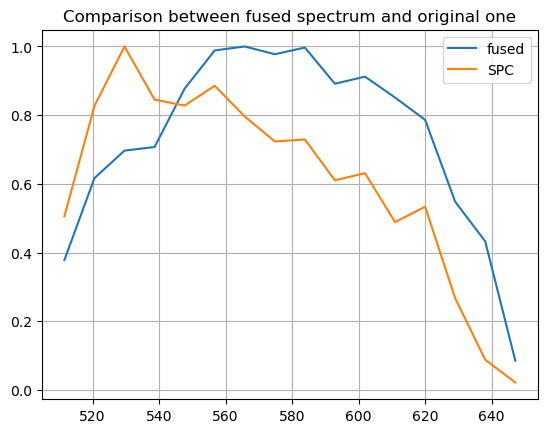

In [14]:
global_spectrum_fused = np.mean(x, axis=(0, 2, 3, 4))
global_spectrum_fused = global_spectrum_fused / np.max(global_spectrum_fused)
global_spectrum_original = spc.mean(axis=(0, 2, 3))
global_spectrum_original = global_spectrum_original / np.max(global_spectrum_original)
plt.plot(lam, global_spectrum_fused, label="fused")
plt.plot(lam, global_spectrum_original, label="SPC")
plt.title("Comparison between fused spectrum and original one")
plt.legend()
plt.grid()

plt.show()

## Save data

In [10]:
SAVE_PATH = RESOURCES_PATH / "520_kidney2_550_550_610_SPC_raw_proc_tlxy_fused_PROVA.npz"
if not SAVE_PATH.is_file():
    np.savez(SAVE_PATH, x=x.astype(np.float16), t=t, lam=lam, weights=weights, lr=lr, iterations=iterations)
else:
    warnings.warn("File name already exists!")

NameError: name 'lr' is not defined